In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Funzioni

In [ ]:
def train_test_classes_split(dataset, target_key, train_sizes, random_state=None):
  X_tr = pd.DataFrame()
  X_ts = pd.DataFrame()
  y_tr = pd.DataFrame()
  y_ts = pd.DataFrame()

  for c in train_sizes.keys():
    ds = dataset[dataset[target_key] == c]
    y_c = ds[target_key]
    X_c = ds.drop(columns=target_key)
    X_tr_c, X_ts_c, y_tr_c, y_ts_c = train_test_split(X_c, y_c,
                                                      random_state=random_state,
                                                      train_size=train_sizes[c])
    X_tr = pd.concat([X_tr, X_tr_c])
    X_ts = pd.concat([X_ts, X_ts_c])
    y_tr = pd.concat([y_tr, y_tr_c])
    y_ts = pd.concat([y_ts, y_ts_c])

  # print(X_tr_my.shape, X_ts_my.shape, y_tr_my.shape, y_ts_my.shape)
  return X_tr, X_ts, y_tr, y_ts

In [ ]:
def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  print('Confusion matrix:\n', metrics.confusion_matrix(y_test, y_pred))
  return y_test, y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    dataset.drop(columns=columns, inplace=True)
  dataset = pd.concat([dataset, dummies], axis=1)
  return dataset

In [ ]:
def xtab(dataset, index_col, columns_col, normalize_on_idx=False):
  xtab = pd.crosstab(dataset[index_col], dataset[columns_col])
  if normalize_on_idx:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / len(dataset[dataset[index_col] == i])
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

# Parte 1: Analisi

1. Caricare il dataset e denominarlo con una variabile chiamata “dataset”

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/BankMarketingDataSet.csv', sep=';')
dataset.head()

,id,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1,30,blue-collar,married,basic.9y,no,yes,no,-1.8,92.893,-46.2,1.313,5099.1,no
1,2,39,services,single,high.school,no,no,no,1.1,93.994,-36.4,4.855,5191.0,no
2,3,25,services,married,high.school,no,yes,no,1.4,94.465,-41.8,4.962,5228.1,no
3,4,38,services,married,basic.9y,no,unknown,unknown,1.4,94.465,-41.8,4.959,5228.1,no
4,5,47,admin.,married,university.degree,no,yes,no,-0.1,93.200,-42.0,4.191,5195.8,no


2. Quante sono le istanze contenute nel dataset? Il dataset è completo (cioè per ogni istanza tutti i valori di attributo sono sempre specificati – non esistono “missing values”)? Il dataset è bilanciato per quanto riguarda la classe da predire?

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4119 non-null   int64  
 1   age             4119 non-null   int64  
 2   job             4119 non-null   object 
 3   marital         4119 non-null   object 
 4   education       4119 non-null   object 
 5   default         4119 non-null   object 
 6   housing         4119 non-null   object 
 7   loan            4119 non-null   object 
 8   emp.var.rate    4119 non-null   float64
 9   cons.price.idx  4119 non-null   float64
 10  cons.conf.idx   4119 non-null   float64
 11  euribor3m       4119 non-null   float64
 12  nr.employed     4119 non-null   float64
 13  y               4119 non-null   object 
dtypes: float64(5), int64(2), object(7)
memory usage: 450.6+ KB


In [ ]:
dataset.y.value_counts() / dataset.y.size

no     0.890507
yes    0.109493
Name: y, dtype: float64

3. Visualizzare la distribuzione delle età in uno specifico diagramma

(array([  0.,   4.,  94., 453., 928., 760., 567., 481., 405., 317.,  52.,
         19.,  15.,  11.,  10.]),
 array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]),
 <a list of 15 Patch objects>)

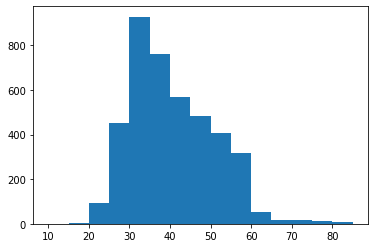

In [ ]:
plt.hist(dataset.age, bins=range(10, 90, 5))

4. Attraverso l’analisi del dataset è possibile ipotizzare se l’attributo “marital status” influisce nella predizione? In che modo influisce? Giustificare la risposta.

y               no       yes
marital                     
divorced  0.903587  0.096413
married   0.899562  0.100438
single    0.865568  0.134432
unknown   0.909091  0.090909


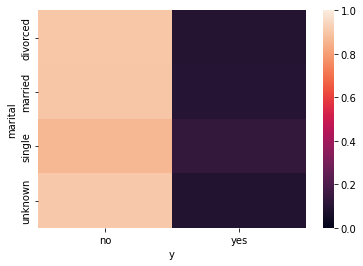

In [ ]:
_ = xtab(dataset, 'marital', 'y', normalize_on_idx=True)

y          no       yes
age                    
18   0.666667  0.333333
19   1.000000  0.000000
20   1.000000  0.000000
21   0.571429  0.428571
22   0.800000  0.200000
..        ...       ...
81   0.333333  0.666667
82   0.000000  1.000000
85   1.000000  0.000000
86   0.000000  1.000000
88   1.000000  0.000000

[67 rows x 2 columns]


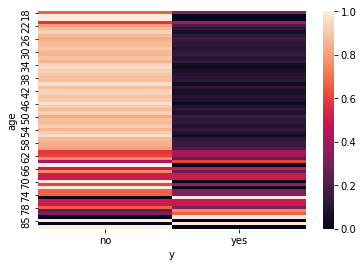

In [ ]:
age_xtab = xtab(dataset, 'age', 'y', normalize_on_idx=True)

y               no       yes
age_bins                    
(10, 20]  0.875000  0.125000
(20, 30]  0.877778  0.122222
(30, 40]  0.903965  0.096035
(40, 50]  0.909709  0.090291
(50, 60]  0.881737  0.118263
(60, 70]  0.619048  0.380952
(70, 80]  0.535714  0.464286
(80, 90]  0.333333  0.666667


(0, 10]         0
(10, 20]        8
(20, 30]      720
(30, 40]     1614
(40, 50]     1030
(50, 60]      668
(60, 70]       42
(70, 80]       28
(80, 90]        9
(90, 100]       0
Name: age_bins, dtype: int64

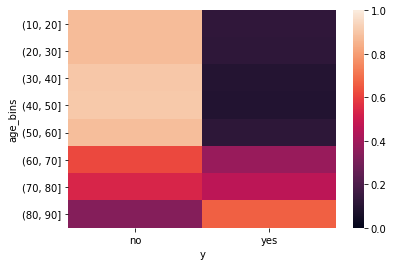

In [ ]:
dataset_age_bins = dataset.copy()
dataset_age_bins['age_bins'] = pd.cut(dataset_age_bins.age, bins=range(0, 101, 10))

xtab(dataset_age_bins, 'age_bins', 'y', normalize_on_idx=True)

dataset_age_bins.age_bins.value_counts(sort=False, ascending=True)

# Parte 2: Trasformazione e Predizione

Trasformare i valori categorici in valori numerici assegnando un valore specifico a ogni categoria
di valori. In particolare, assegnare il valore 0 al valore “no” dell’attributo “y” e 1 al valore
“yes”.
Eliminare eventuali attributi che per qualche ragione (Specificarla) si ritiene essere inutili per la
classificazione. Eliminare tutte le istanze per le quali c’è un attributo che assume valore
unknown.

In [ ]:
dataset0 = dataset.copy()

y                    no       yes
job                              
admin.         0.868577  0.131423
blue-collar    0.930995  0.069005
entrepreneur   0.945946  0.054054
housemaid      0.900000  0.100000
management     0.907407  0.092593
retired        0.771084  0.228916
self-employed  0.918239  0.081761
services       0.910941  0.089059
student        0.768293  0.231707
technician     0.884226  0.115774
unemployed     0.828829  0.171171
unknown        0.897436  0.102564
y               no       yes
marital                     
divorced  0.903587  0.096413
married   0.899562  0.100438
single    0.865568  0.134432
unknown   0.909091  0.090909
y                          no       yes
education                              
basic.4y             0.911422  0.088578
basic.6y             0.925439  0.074561
basic.9y             0.925087  0.074913
high.school          0.894680  0.105320
illiterate           1.000000  0.000000
professional.course  0.878505  0.121495
university.degree    0.869462 

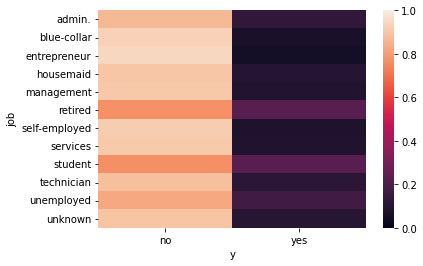

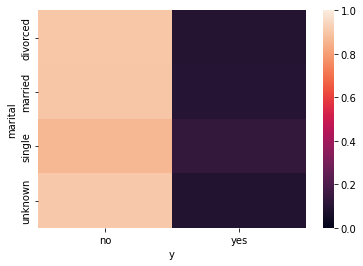

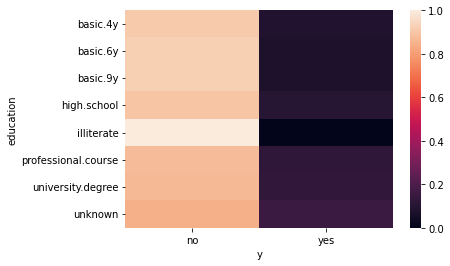

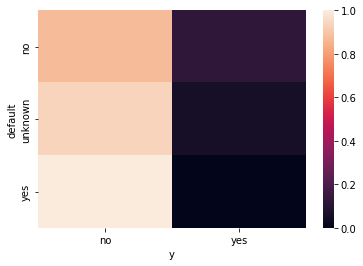

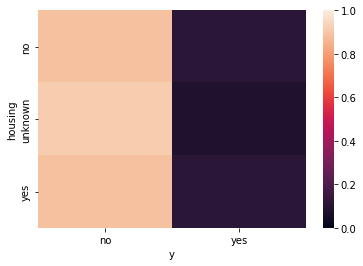

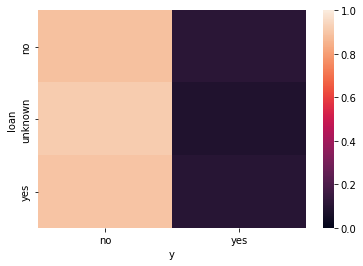

In [ ]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan']

for c in categorical:
  plt.figure()
  _ = xtab(dataset, c, 'y', normalize_on_idx=True)

In [ ]:
y = {
    'yes' : 1,
    'no'  : 0,
}

replace = {
    'y' : y
}

dataset.replace(replace, inplace=True)
dataset.head()

,id,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1,30,blue-collar,married,basic.9y,no,yes,no,-1.8,92.893,-46.2,1.313,5099.1,0
1,2,39,services,single,high.school,no,no,no,1.1,93.994,-36.4,4.855,5191.0,0
2,3,25,services,married,high.school,no,yes,no,1.4,94.465,-41.8,4.962,5228.1,0
3,4,38,services,married,basic.9y,no,unknown,unknown,1.4,94.465,-41.8,4.959,5228.1,0
4,5,47,admin.,married,university.degree,no,yes,no,-0.1,93.200,-42.0,4.191,5195.8,0


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

job = dataset.job.unique()
job = np.delete(job, np.where(job == 'unknown'))
marital = dataset.marital.unique()
marital = np.delete(marital, np.where(marital == 'unknown'))
education = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y','high.school',
             'professional.course', 'university.degree'] # ascending order
default = ['no', 'yes']
housing = ['no', 'yes']
loan = ['no', 'yes']
# encode 'Unknown' as np.nan, to subsequently drop it with dropna()
enc = OrdinalEncoder(categories=[job, marital, education, default, housing, loan],
                     handle_unknown='use_encoded_value', unknown_value=np.nan
                     ).fit(dataset[categorical])
enc_ds = pd.DataFrame(enc.transform(dataset[categorical]), columns=categorical)

dataset = pd.concat([dataset.drop(columns=categorical), enc_ds], axis=1)
dataset.head()

,id,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job,marital,education,default,housing,loan
0,1,30,-1.8,92.893,-46.2,1.313,5099.1,0,0.0,0.0,3.0,0.0,1.0,0.0
1,2,39,1.1,93.994,-36.4,4.855,5191.0,0,1.0,1.0,4.0,0.0,0.0,0.0
2,3,25,1.4,94.465,-41.8,4.962,5228.1,0,1.0,0.0,4.0,0.0,1.0,0.0
3,4,38,1.4,94.465,-41.8,4.959,5228.1,0,1.0,0.0,3.0,0.0,NaN,NaN
4,5,47,-0.1,93.200,-42.0,4.191,5195.8,0,2.0,0.0,6.0,0.0,1.0,0.0


In [ ]:
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

y            0         1
job                     
0.0   0.915162  0.084838
1.0   0.913043  0.086957
2.0   0.861827  0.138173
3.0   0.934579  0.065421
4.0   0.896825  0.103175
5.0   0.879581  0.120419
6.0   0.909434  0.090566
7.0   0.745455  0.254545
8.0   0.756303  0.243697
9.0   0.880000  0.120000
10.0  0.813953  0.186047
y               0         1
marital                    
0.0      0.888889  0.111111
1.0      0.860147  0.139853
2.0      0.890805  0.109195
y                 0         1
education                    
0.0        1.000000  0.000000
1.0        0.897119  0.102881
2.0        0.920000  0.080000
3.0        0.911548  0.088452
4.0        0.880495  0.119505
5.0        0.874449  0.125551
6.0        0.861789  0.138211
y              0        1
default                  
0.0      0.88022  0.11978
1.0      1.00000  0.00000
y               0         1
housing                    
0.0      0.883738  0.116262
1.0      0.877370  0.122630
y            0         1
loan                    

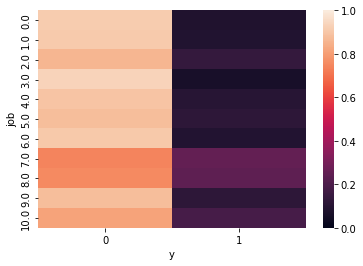

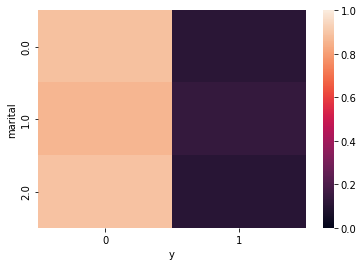

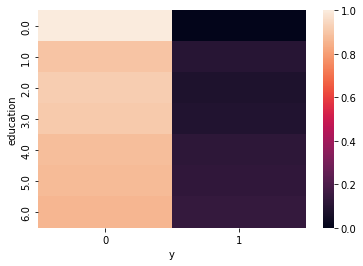

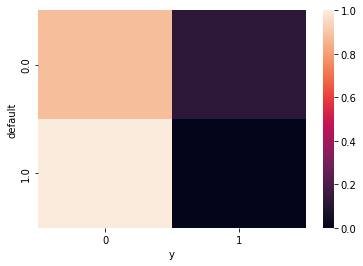

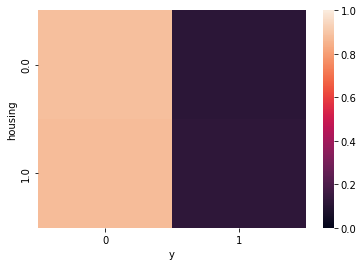

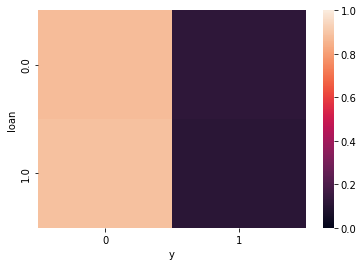

In [ ]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan']

for c in categorical:
  plt.figure()
  xtab(dataset, c, 'y', normalize_on_idx=True)

y                     no       yes
age                               
(17.999, 28.8]  0.868932  0.131068
(28.8, 31.0]    0.877712  0.122288
(31.0, 33.0]    0.878238  0.121762
(33.0, 35.0]    0.947977  0.052023
(35.0, 38.0]    0.905495  0.094505
(38.0, 41.0]    0.903394  0.096606
(41.0, 45.0]    0.921615  0.078385
(45.0, 50.0]    0.906926  0.093074
(50.0, 55.0]    0.886598  0.113402
(55.0, 88.0]    0.805014  0.194986
y                     no       yes
emp.var.rate                      
(-3.401, -1.8]  0.797782  0.202218
(-1.8, -1.7]    0.482759  0.517241
(-1.7, -0.1]    0.884454  0.115546
(-0.1, 1.1]     0.967018  0.032982
(1.1, 1.4]      0.945264  0.054736
y                                  no       yes
cons.price.idx                                 
(92.19999999999999, 92.893]  0.830346  0.169654
(92.893, 93.2]               0.888218  0.111782
(93.2, 93.444]               0.931034  0.068966
(93.444, 93.749]             0.357143  0.642857
(93.749, 93.918]             0.913793  0.086207

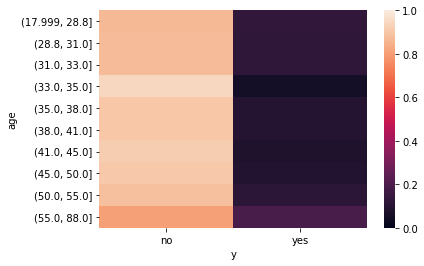

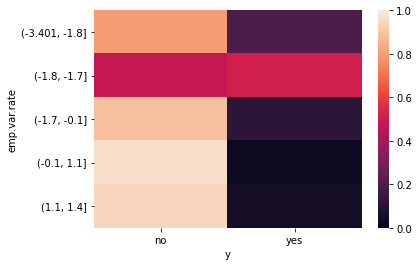

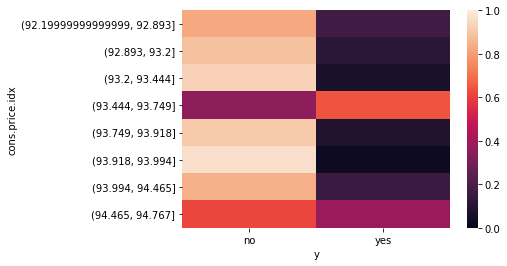

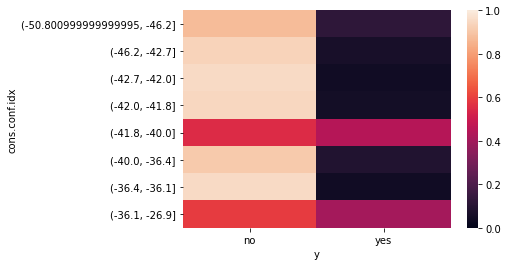

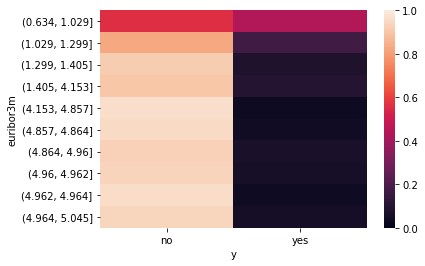

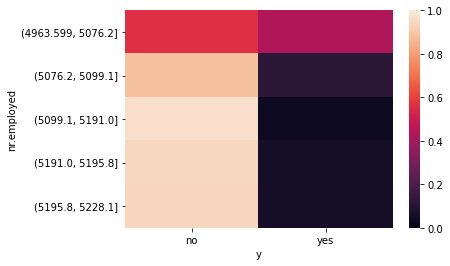

In [ ]:
numerical = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

discretized = dataset0.copy()
for n in numerical:
  plt.figure()
  # discretized[n] = pd.cut(discretized[n], bins=20)
  discretized[n] = pd.qcut(discretized[n], q=10, duplicates='drop')
  xtab(discretized, n, 'y', normalize_on_idx=True)

In [ ]:
dataset.drop(columns='id', inplace=True)
# ID identifica ogni singola istanza ma non aggiunge alcuna informazione utile
# ai fini della predizione: al contrario, causerebbe un eccessiva e inutile
# ramificazione dell'algoritmo

In [ ]:
dataset1 = dataset.copy()

In [ ]:
train, test = train_test_split(dataset, train_size=.75, random_state=1)

In [ ]:
X_tr = train.drop(columns='y')
y_tr = train['y']
X_ts = test.drop(columns='y')
y_ts = test['y']

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.9991368148467846
Confusion matrix:
 [[2031    0]
 [   2  284]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

Accuracy: 0.8033635187580854
Confusion matrix:
 [[604  85]
 [ 67  17]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, KNeighborsClassifier())

Accuracy: 0.908933966335779
Confusion matrix:
 [[1986   45]
 [ 166  120]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, KNeighborsClassifier())

Accuracy: 0.8732212160413971
Confusion matrix:
 [[655  34]
 [ 64  20]]


In [ ]:
X = dataset.drop(columns='y')
y = dataset.y

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=10,
                n_jobs=-1).mean()

0.8126213592233009

In [ ]:
cross_val_score(KNeighborsClassifier(), X, y, scoring='accuracy', cv=10,
                n_jobs=-1).mean()

0.8783171521035598

In [ ]:
"""
Il metodo cross validation è ritenuto il migliore per allenare un algoritmo
perchè, all'interno di un ciclo, utilizza tutto il dataset sia per il training
che per il testing
"""

In [ ]:
numeric = dataset.drop(columns=categorical)

In [ ]:
numeric.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,1.1,93.994,-36.4,4.855,5191.0,0
2,25,1.4,94.465,-41.8,4.962,5228.1,0
3,47,-0.1,93.200,-42.0,4.191,5195.8,0
4,32,-1.1,94.199,-37.5,0.884,4963.6,0


In [ ]:
train, test = train_test_split(numeric, train_size=.75, random_state=1)

In [ ]:
X_tr = train.drop(columns='y')
y_tr = train['y']
X_ts = test.drop(columns='y')
y_ts = test['y']

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.9702201122140699
Confusion matrix:
 [[2030    1]
 [  68  218]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

Accuracy: 0.8421733505821475
Confusion matrix:
 [[630  59]
 [ 63  21]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, KNeighborsClassifier())

Accuracy: 0.9028916702632714
Confusion matrix:
 [[1972   59]
 [ 166  120]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, KNeighborsClassifier())

Accuracy: 0.869340232858991
Confusion matrix:
 [[649  40]
 [ 61  23]]


In [ ]:
enc_ds = pd.DataFrame(enc.inverse_transform(dataset[categorical]), columns=categorical)

numeric = pd.concat([numeric, enc_ds], axis=1)
numeric.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job,marital,education,default,housing,loan
0,30,-1.8,92.893,-46.2,1.313,5099.1,0,blue-collar,married,basic.9y,no,yes,no
1,39,1.1,93.994,-36.4,4.855,5191.0,0,services,single,high.school,no,no,no
2,25,1.4,94.465,-41.8,4.962,5228.1,0,services,married,high.school,no,yes,no
3,47,-0.1,93.200,-42.0,4.191,5195.8,0,admin.,married,university.degree,no,yes,no
4,32,-1.1,94.199,-37.5,0.884,4963.6,0,services,single,university.degree,no,no,no


In [ ]:
numeric = add_dummies(numeric, ['job', 'marital', 'education'])
numeric.head()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,default,housing,loan,blue-collar,services,admin.,self-employed,technician,management,retired,entrepreneur,housemaid,unemployed,student,married,single,divorced,basic.9y,high.school,university.degree,professional.course,basic.4y,basic.6y,illiterate
0,30,-1.8,92.893,-46.2,1.313,5099.1,0,no,yes,no,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39,1.1,93.994,-36.4,4.855,5191.0,0,no,no,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,25,1.4,94.465,-41.8,4.962,5228.1,0,no,yes,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,47,-0.1,93.200,-42.0,4.191,5195.8,0,no,yes,no,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,32,-1.1,94.199,-37.5,0.884,4963.6,0,no,no,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
booleans = ['default', 'housing', 'loan']
numeric = add_dummies(numeric, booleans, drop_cat=['no', 'no', 'no'])

In [ ]:
columns = numeric.columns[:-3].tolist() + booleans
numeric.set_axis(columns, axis=1, inplace=True)

In [ ]:
train, test = train_test_split(numeric, train_size=.75, random_state=1)

In [ ]:
X_tr = train.drop(columns='y')
y_tr = train['y']
X_ts = test.drop(columns='y')
y_ts = test['y']

In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.9991368148467846
Confusion matrix:
 [[2031    0]
 [   2  284]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

Accuracy: 0.8201811125485123
Confusion matrix:
 [[609  80]
 [ 59  25]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, KNeighborsClassifier())

Accuracy: 0.8994389296504101
Confusion matrix:
 [[1966   65]
 [ 168  118]]


In [ ]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, KNeighborsClassifier())

Accuracy: 0.8835705045278137
Confusion matrix:
 [[656  33]
 [ 57  27]]


In [ ]:
train, test = train_test_split(dataset1, train_size=.75, random_state=1)

In [ ]:
X_tr = train.drop(columns='y')
y_tr = train['y']
X_ts = test.drop(columns='y')
y_ts = test['y']

In [ ]:
from sklearn.linear_model import LinearRegression
lnr = LinearRegression().fit(X_tr, y_tr)
y_pr = np.around(lnr.predict(X_ts))

In [ ]:
metrics.accuracy_score(y_ts, y_pr)

0.8835705045278137

In [ ]:
metrics.confusion_matrix(y_ts, y_pr)

array([[679,  10],
       [ 80,   4]])

In [ ]:
# Teoria